## Basic import

In [1]:
# Basic setting for Jupyter_notebook to import utils
import os
import sys

notebook_path = os.path.abspath("")
project_root = os.path.abspath(os.path.join(notebook_path, "../../"))

sys.path.append(project_root)

In [66]:
import os
import xarray as xr
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
from utils import folder_utils

## Basic function

In [3]:

# Example usage
country = "GB"
data_folder = "data"
data_read_category = "raw_data"
data_test_category = "test_data"
data_save_category = "processed_data"
output_folder = "ASOS_DATA"

In [34]:
def get_year_from_filename(filename):
    # extract year from filename
    # filename = "GB_merged_ASOS_1979.csv"
    parts = filename.split("_")
    return parts[3]

In [35]:
def get_asos_year_file_list(country, data_folder, data_category, output_folder):
    input_folder_path = folder_utils.find_folder(
        country, data_folder, data_category, output_folder
    )
    csv_files = [
        f
        for f in os.listdir(input_folder_path)
        if f.endswith(".csv") and "_merged_ASOS_" in f
    ]

    # sort by year
    csv_files.sort(key=lambda x: get_year_from_filename(x))

    return [
        os.path.join(input_folder_path, csv_file) for csv_file in csv_files
    ]  # return the full path

In [5]:
def csv_to_nc4(merged_csv_path,year, country, data_folder, data_category, output_folder):
    """Convert the merged CSV file to netCDF4 format by year."""
    df = pd.read_csv(merged_csv_path)
    ds_in = xr.Dataset.from_dataframe(df.set_index(['latitude', 'longitude', 'time']))
    ds_in = ds_in.sel(latitude=slice(50, 58), longitude=slice(-6, 2))
    ddeg_out_lat = 0.25
    ddeg_out_lon = 0.125
    regridded_ds = regrid(ds_in, ddeg_out_lat, ddeg_out_lon, method="bilinear", reuse_weights=False)

    output_directory = folder_utils.find_folder(country,data_folder,data_category,output_folder)
    output_filename = f"{country}_ASOS_regird_{year}.nc"
    output_path = os.path.join(output_directory, output_filename)
    regridded_ds.to_netcdf(output_path)
    print(f"{output_filename} done!")

In [6]:
def get_year(start_year, end_year):
    # start_year = 1979
    # end_year = 2023
    year_list = list(range(start_year, end_year + 1))

    # Convert the integer list to a string list
    year_str_list = [str(year) for year in year_list]

    return year_str_list

## Test example

In [7]:
year_list = get_year(start_year=1979, end_year=2023)

In [36]:
csv_paths = get_asos_year_file_list(
    country, data_folder, data_save_category, output_folder
)

In [37]:
csv_paths

['/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/processed_data/ASOS_DATA/GB_ASOS_DATA/GB_merged_ASOS_1979.csv',
 '/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/processed_data/ASOS_DATA/GB_ASOS_DATA/GB_merged_ASOS_1980.csv',
 '/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/processed_data/ASOS_DATA/GB_ASOS_DATA/GB_merged_ASOS_1981.csv',
 '/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/processed_data/ASOS_DATA/GB_ASOS_DATA/GB_merged_ASOS_1982.csv',
 '/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/processed_data/ASOS_DATA/GB_ASOS_DATA/GB_merged_ASOS_1983.csv',
 '/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/processed_data/ASOS_DATA/GB_ASOS_DATA/GB_merged_ASOS_1984.csv',
 '/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/processed_data/ASOS_DATA/GB_ASOS_DATA/GB_merged_ASOS_1985.csv',
 '/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakc

In [ ]:
# csv_to_nc4(csv_path, year, country, data_folder, data_save_category, output_folder)

In [43]:
"""Convert the merged CSV file to netCDF4 format by year."""
df = pd.read_csv(csv_paths[25])


In [44]:
df

,latitude,longitude,time,t2m
0,57.2049,-2.2053,2004-01-01 00:00:00,276.0
1,57.2049,-2.2053,2004-01-01 01:00:00,276.0
2,57.2049,-2.2053,2004-01-01 02:00:00,276.5
3,57.2049,-2.2053,2004-01-01 03:00:00,276.8
4,57.2049,-2.2053,2004-01-01 04:00:00,277.3
...,...,...,...,...
550074,51.0063,-2.6428,2004-12-31 19:00:00,281.5
550075,51.0063,-2.6428,2004-12-31 20:00:00,280.9
550076,51.0063,-2.6428,2004-12-31 21:00:00,281.5
550077,51.0063,-2.6428,2004-12-31 22:00:00,281.0


In [46]:
def filter_data(df):
    """
    Filter data by deleting rows with missing values and wrong values
    """
    # Delete rows with missing values
    df = df.dropna()
   # Convert to datetime
    df["time"] = pd.to_datetime(df["time"])  # Convert to datetime

    # If the time is not a whole hour, delete the row
    is_whole_hour = (df["time"].dt.minute == 0) & (df["time"].dt.second == 0)
    not_null = df["time"].notnull()
    latitude_condition = (df["latitude"] >= 50) & (df["latitude"] <= 58)
    longitude_condition = (df["longitude"] >= -6) & (df["longitude"] <= 2)
    # Combine all conditions
    combined_condition = (
        is_whole_hour & not_null & latitude_condition & longitude_condition
    )

    filtered_df = df[combined_condition]

    return filtered_df


In [47]:
df = filter_data(df)
df

/var/folders/tt/fs_l1by51m30s907pzxq6gf40000gp/T/ipykernel_23224/2189851267.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time"] = pd.to_datetime(df["time"])  # Convert to datetime


,latitude,longitude,time,t2m
0,57.2049,-2.2053,2004-01-01 00:00:00,276.0
1,57.2049,-2.2053,2004-01-01 01:00:00,276.0
2,57.2049,-2.2053,2004-01-01 02:00:00,276.5
3,57.2049,-2.2053,2004-01-01 03:00:00,276.8
4,57.2049,-2.2053,2004-01-01 04:00:00,277.3
...,...,...,...,...
550074,51.0063,-2.6428,2004-12-31 19:00:00,281.5
550075,51.0063,-2.6428,2004-12-31 20:00:00,280.9
550076,51.0063,-2.6428,2004-12-31 21:00:00,281.5
550077,51.0063,-2.6428,2004-12-31 22:00:00,281.0


In [62]:
ds_in = xr.Dataset.from_dataframe(df.set_index(['latitude', 'longitude', 'time']))

# 调整维度顺序，并更改数据类型
ds_adjusted = ds_in.transpose("time", "latitude", "longitude")
ds_adjusted["t2m"] = ds_adjusted["t2m"].astype("float32")

print(ds_adjusted)


<xarray.Dataset>
Dimensions:    (latitude: 80, longitude: 80, time: 8784)
Coordinates:
  * latitude   (latitude) float64 50.08 50.42 50.44 50.74 ... 57.65 57.71 57.82
  * longitude  (longitude) float64 -5.873 -5.686 -5.257 ... 1.3 1.346 1.357
  * time       (time) datetime64[ns] 2004-01-01 ... 2004-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 nan nan 282.3 ... nan nan nan


In [67]:
a = np.asarray(ds_adjusted['t2m'])

In [69]:
a.shape

(8784, 80, 80)

In [74]:
a[3][0]

array([  nan,   nan, 281.8,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan],
      dtype=float32)

## UK_background

### Modification from gstools

Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_TR', 'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT',
       'FCLASS_NL', 'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'geometry'],
      dtype='object', length=169)


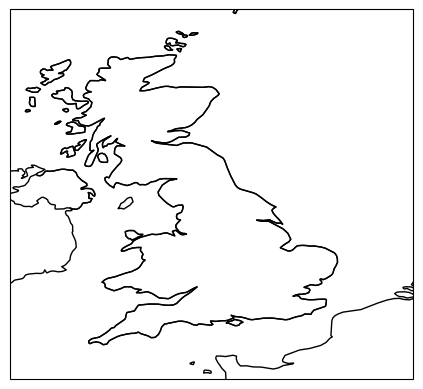

In [128]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io import shapereader

# 下载简化的英国边界 shapefile
shpfile = shapereader.natural_earth("50m", "cultural", "admin_0_countries")

# 使用 GeoPandas 读取 shapefile
gdf = gpd.read_file(shpfile)
# print(gdf.columns)

# 选择英国的边界
uk_border = gdf[gdf["ADMIN"] == "United Kingdom"]


# 保存英国边界为 GeoJSON 文件
uk_border.to_file("uk_border.geojson", driver="GeoJSON")

# 或者保存为 Shapefile 文件
uk_border.to_file("uk_border.shp")


# 创建地图和投影
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ax.add_geometries(uk_border.geometry, crs=ccrs.PlateCarree(), edgecolor="black", facecolor="none")

# 设置地图属性
ax.coastlines(resolution="50m")
ax.set_extent([-8, 4, 49, 60], crs=ccrs.PlateCarree())  # 设置地图显示范围（经度、纬度）

# 显示地图
plt.show()


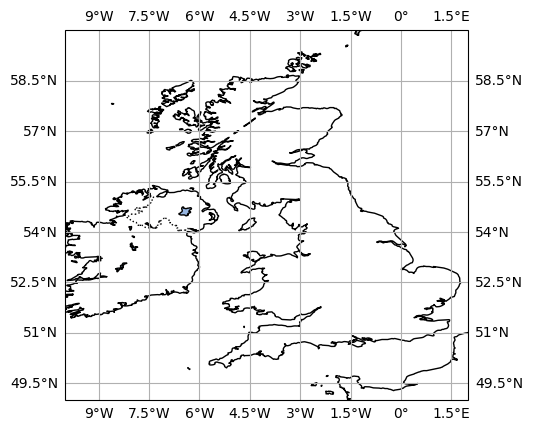

In [121]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_uk_border():
    # 创建一个matplotlib的图和坐标轴，使用PlateCarree投影
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    
    # 设置地理范围为英国周边
    ax.set_extent([-10, 2, 49, 60], crs=ccrs.PlateCarree())
    
    # 添加英国的边界
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    # 添加海岸线和湖泊
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAKES, edgecolor='black')
    
    # 添加网格线
    ax.gridlines(draw_labels=True)
    
    # 显示图像
    plt.show()

plot_uk_border()


### coarse version 

In [ ]:
import geopandas as gpd

def download_uk_border():
    # 从Natural Earth下载全球国家边界数据
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # 提取英国的边界数据
    uk = world[world['name'] == "United Kingdom"]

    # 保存英国的边界到Shapefile
    uk.to_file("UK_border.shp")

download_uk_border()


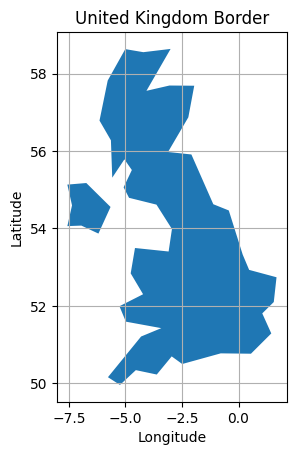

In [125]:
# 从Shapefile加载英国的边界数据
uk_border = gpd.read_file("UK_border.shp")

# 绘制并显示边界
uk_border.plot()
plt.title("United Kingdom Border")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [126]:
gdf = gpd.read_file('UK_border.shp')

In [127]:
gdf

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,66834405.0,Europe,United Kingdom,GBR,2829108,"MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54.07370, -7.57217 54.05996, -7.36603 54.59584, -7.57217 55.13162, -6.73385 55.17286, -5.66195 54.55460, -6.19788 53.86757)), ((-3.09383 53.40455, -3.09208 53.40444, -2.94501 53.98500, -3.61470 54.60094, -3.63001 54.61501, -4.84417 54.79097, -5.08253 55.06160, -4.71911 55.50847, -5.04798 55.78399, -5.58640 55.31115, -5.64500 56.27501, -6.14998 56.78501, -5.78682 57.81885, -5.01000 58.63001, -4.21149 58.55085, -3.00500 58.63500, -4.07383 57.55302, -3.05500 57.69002, -1.95928 57.68480, -2.21999 56.87002, -3.11900 55.97379, -2.08501 55.91000, -2.00568 55.80490, -1.11499 54.62499, -0.43048 54.46438, 0.18498 53.32501, 0.46998 52.93000, 1.68153 52.73952, 1.55999 52.10000, 1.05056 51.80676, 1.44987 51.28943, 0.55033 50.76574, -0.78752 50.77499, -2.49000 50.50002, -2.95627 50.69688, -3.61745 50.22836, -4.54251 50.34184, -5.24502 49.96000, -5.77657 50.15968, -4.30999 51.21000, -3.41485 51.42601, -3.42272 51.42685, -4.98437 51.59347, -5.26730 51.99140, -4.22235 52.30136, -4.77001 52.84000, -4.58000 53.49500, -3.09383 53.40455)))"


## Regrid

### test1

In [129]:
gridx = np.linspace(-6.0, 1.875, 64)

In [130]:
gridx

array([-6.   , -5.875, -5.75 , -5.625, -5.5  , -5.375, -5.25 , -5.125,
       -5.   , -4.875, -4.75 , -4.625, -4.5  , -4.375, -4.25 , -4.125,
       -4.   , -3.875, -3.75 , -3.625, -3.5  , -3.375, -3.25 , -3.125,
       -3.   , -2.875, -2.75 , -2.625, -2.5  , -2.375, -2.25 , -2.125,
       -2.   , -1.875, -1.75 , -1.625, -1.5  , -1.375, -1.25 , -1.125,
       -1.   , -0.875, -0.75 , -0.625, -0.5  , -0.375, -0.25 , -0.125,
        0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,  0.75 ,  0.875,
        1.   ,  1.125,  1.25 ,  1.375,  1.5  ,  1.625,  1.75 ,  1.875])

In [133]:
gridy = np.linspace(50.0, 57.75, 32) 

In [134]:
gridy

array([50.  , 50.25, 50.5 , 50.75, 51.  , 51.25, 51.5 , 51.75, 52.  ,
       52.25, 52.5 , 52.75, 53.  , 53.25, 53.5 , 53.75, 54.  , 54.25,
       54.5 , 54.75, 55.  , 55.25, 55.5 , 55.75, 56.  , 56.25, 56.5 ,
       56.75, 57.  , 57.25, 57.5 , 57.75])

### test2

#### basic import

In [143]:
import os
import pandas as pd
import numpy as np
import xarray as xr
import gstools as gs
import geopandas as gpd
import matplotlib.pyplot as plt
from utils import folder_utils
from tqdm import tqdm

In [137]:
def krige_regrid(
    year_df_path, year, country, data_folder, data_category, output_folder
):
    # 1. Load the data
    df = pd.read_csv(year_df_path)
    lat = df["latitude"].values
    lon = df["longitude"].values

    # 2. Create a new dataframe to store the interpolated data
    output_df = pd.DataFrame()

    # 3.Define the grid
    g_lon = np.linspace(-6.0, 1.875, 64)  # longitude
    g_lat = np.linspace(50.0, 57.5, 32)  # latitude
    # gridx, gridy = np.meshgrid(gridx, gridy)

    # 4. Drift term
    def north_south_drift(lat, lon):
        return lat

    unique_times = df["time"].unique()

    # Iterate over each time
    for time_point in unique_times:
        # 1. Load data
        t2m = df[df["time"] == time_point]["t2m"].values

        # 2. Estimate the variogram
        bin_center, vario = gs.vario_estimate(
            (lat, lon), t2m, latlon=True, geo_scale=gs.KM_SCALE, max_dist=900
        )

        # 3. krige interpolation
        model = gs.Spherical(latlon=True, geo_scale=gs.KM_SCALE)
        model.fit_variogram(bin_center, vario, nugget=False)

        # 5. Universal Kriging

        uk = gs.krige.Universal(
            model=model,
            cond_pos=(lat, lon),
            cond_val=t2m,
            drift_functions=north_south_drift,
        )

        uk.set_pos((g_lat, g_lon), mesh_type="structured")
        interpolated_values = uk(return_var=False)

        temp_df = pd.DataFrame(
            {
                "lat": np.tile(g_lat, len(g_lon)),
                "lon": np.repeat(g_lon, len(g_lat)),
                "time": [time_point] * len(g_lat) * len(g_lon),
                "t2m": interpolated_values.ravel(),
            }
        )

        output_df = pd.concat([output_df, temp_df], ignore_index=True)

    # Save to csv file
    output_directory = folder_utils.find_folder(
        country, data_folder, data_category, output_folder
    )
    output_filename = f"{country}_ASOS_krige_{year}.csv"
    output_path = os.path.join(output_directory, output_filename)
    output_df.to_csv(output_path, index=False)

In [138]:
def get_year(start_year, end_year):
    # start_year = 1979
    # end_year = 2023
    year_list = list(range(start_year, end_year + 1))

    # Convert the integer list to a string list
    year_str_list = [str(year) for year in year_list]

    return year_str_list


def get_year_from_filename(filename):
    # extract year from filename
    # filename = "GB_merged_ASOS_1979.csv"
    parts = filename.split("_")
    return parts[3]


def get_asos_year_file_list(country, data_folder, data_category, output_folder):
    input_folder_path = folder_utils.find_folder(
        country, data_folder, data_category, output_folder
    )
    csv_files = [
        f
        for f in os.listdir(input_folder_path)
        if f.endswith(".csv") and "_merged_ASOS_" in f
    ]

    # sort by year
    csv_files.sort(key=lambda x: get_year_from_filename(x))

    return [
        os.path.join(input_folder_path, csv_file) for csv_file in csv_files
    ]  # return the full path


#### example

In [146]:
# Example usage
country = "GB"
data_folder = "data"
data_read_category = "raw_data"
data_test_category = "test_data"
data_save_category = "processed_data"
output_folder = "ASOS_DATA"

In [139]:
year_list = get_year(start_year=1979, end_year=2023)

In [140]:
csv_paths = get_asos_year_file_list(
    country, data_folder, data_save_category, output_folder
)

In [144]:
test_path =csv_paths[0]

In [145]:
krige_regrid(test_path, 1979, country, data_folder, data_save_category, output_folder)

NameError: name 'data_category' is not defined

In [ ]:
def krige_regrid(
    year_df_path, year, country, data_folder, data_category, output_folder
):
    # 1. Load the data
    df = pd.read_csv(year_df_path)
    lat = df["latitude"].values
    lon = df["longitude"].values

    # 2. Create a new dataframe to store the interpolated data
    output_df = pd.DataFrame()

    # 3.Define the grid
    g_lon = np.linspace(-6.0, 1.875, 64)  # longitude
    g_lat = np.linspace(50.0, 57.5, 32)  # latitude
    # gridx, gridy = np.meshgrid(gridx, gridy)

    # 4. Drift term
    def north_south_drift(lat, lon):
        return lat

    unique_times = df["time"].unique()

    # Iterate over each time
    for time_point in unique_times:
        # 1. Load data
        t2m = df[df["time"] == time_point]["t2m"].values

        # 2. Estimate the variogram
        bin_center, vario = gs.vario_estimate(
            (lat, lon), t2m, latlon=True, geo_scale=gs.KM_SCALE, max_dist=900
        )

        # 3. krige interpolation
        model = gs.Spherical(latlon=True, geo_scale=gs.KM_SCALE)
        model.fit_variogram(bin_center, vario, nugget=False)

        # 5. Universal Kriging

        uk = gs.krige.Universal(
            model=model,
            cond_pos=(lat, lon),
            cond_val=t2m,
            drift_functions=north_south_drift,
        )

        uk.set_pos((g_lat, g_lon), mesh_type="structured")
        interpolated_values = uk(return_var=False)

        temp_df = pd.DataFrame(
            {
                "lat": np.tile(g_lat, len(g_lon)),
                "lon": np.repeat(g_lon, len(g_lat)),
                "time": [time_point] * len(g_lat) * len(g_lon),
                "t2m": interpolated_values.ravel(),
            }
        )

        output_df = pd.concat([output_df, temp_df], ignore_index=True)

    # Save to csv file
    output_directory = folder_utils.find_folder(
        country, data_folder, data_category, output_folder
    )
    output_filename = f"{country}_ASOS_krige_{year}.csv"
    output_path = os.path.join(output_directory, output_filename)
    output_df.to_csv(output_path, index=False)